In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from gensim.downloader import load as gensim_load
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path('data')
OUTPUTS_DIR = Path('outputs')
device = torch.device('cpu')  # Attention viz easier on CPU
sns.set_style("whitegrid")
%matplotlib inline


In [7]:
train_df = pd.read_csv(DATA_DIR / 'train_processed.csv')
test_df = pd.read_csv(DATA_DIR / 'test_processed.csv')
print("Loaded train/test from Lab 1")


Loaded train/test from Lab 1


In [ ]:
# Load pretrained GloVe (small, fast)
print("Loading GloVe...")
embeddings = gensim_load('glove-wiki-gigaword-50')  # 50-dim
print("GloVe loaded")

def text_to_embeddings(text, max_len=50):
    words = text.lower().split()[:max_len]
    vectors = []
    for word in words:
        if word in embeddings:
            vectors.append(embeddings[word])
        else:
            vectors.append(np.zeros(50))  # OOV = zero
    
    # Pad/truncate to max_len
    if len(vectors) < max_len:
        vectors += [np.zeros(50)] * (max_len - len(vectors))
    return np.array(vectors)

# Test
sample_text = train_df['text_clean'].iloc[0]
emb_sample = text_to_embeddings(sample_text)
print(f"Sample embedding shape: {emb_sample.shape}")
print("First 5 words:", sample_text.split()[:5])


Loading GloVe...
✅ GloVe loaded
Sample embedding shape: (50, 50)
First 5 words: ['worsening', 'renal', 'failure', 'no', 'outpatient']


In [9]:
class SelfAttention(nn.Module):
    def __init__(self, d_model=50, n_heads=1, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x: (batch, seq_len, d_model)
        B, T, C = x.shape
        
        Q = self.W_q(x)  # (B,T,C)
        K = self.W_k(x)
        V = self.W_v(x)
        
        # Scaled dot-product: (B,T,T)
        scores = torch.matmul(Q, K.transpose(-2,-1)) / np.sqrt(self.d_k)
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context = torch.matmul(attn_weights, V)  # (B,T,C)
        output = self.W_o(context)
        return output, attn_weights

# Test
test_emb = torch.FloatTensor([text_to_embeddings(sample_text)]).to(device)
attn_layer = SelfAttention(d_model=50).to(device)
output, weights = attn_layer(test_emb)
print(f"Attention output shape: {output.shape}")
print(f"Attention weights shape: {weights.shape}")


Attention output shape: torch.Size([1, 50, 50])
Attention weights shape: torch.Size([1, 50, 50])


In [10]:
class AttentionRiskModel(nn.Module):
    def __init__(self, d_model=50, hidden_dim=64):
        super().__init__()
        self.attention = SelfAttention(d_model)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        attn_out, attn_weights = self.attention(x)
        # Global average pool over sequence
        pooled = attn_out.mean(dim=1)
        risk_score = self.classifier(pooled)
        return risk_score, attn_weights

# Test
model = AttentionRiskModel().to(device)
risk, weights = model(test_emb)
print(f"Risk score: {risk.item():.3f}")
print("Max attention:", weights.max().item())


Risk score: 0.507
Max attention: 0.03535715863108635


In [11]:
# Convert full dataset to embeddings (batch processing)
def dataset_to_embeds(df, max_len=50):
    embeds = []
    texts = []
    for text in df['text_clean']:
        emb = text_to_embeddings(text, max_len)
        embeds.append(emb)
        texts.append(text.split()[:max_len])
    return np.array(embeds), texts

# Use subset for speed (full ~3K takes 2min)
train_subset = train_df.sample(1000, random_state=42)
test_subset = test_df.sample(250, random_state=42)

X_train_emb, train_texts = dataset_to_embeds(train_subset)
X_test_emb, test_texts = dataset_to_embeds(test_subset)
y_train_emb = train_subset['label'].values
y_test_emb = test_subset['label'].values

X_train_torch = torch.FloatTensor(X_train_emb).to(device)
y_train_torch = torch.FloatTensor(y_train_emb).unsqueeze(1).to(device)
X_test_torch = torch.FloatTensor(X_test_emb).to(device)
y_test_torch = torch.FloatTensor(y_test_emb).unsqueeze(1).to(device)

print(f"Train embeds: {X_train_torch.shape}, Test: {X_test_torch.shape}")


Train embeds: torch.Size([1000, 50, 50]), Test: torch.Size([250, 50, 50])


In [12]:
# Train attention model
model = AttentionRiskModel().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_attention(epochs=20):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        risk_pred, _ = model(X_train_torch)
        loss = criterion(risk_pred, y_train_torch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if epoch % 5 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    return train_losses

train_losses = train_attention()

# Evaluate
model.eval()
with torch.no_grad():
    risk_pred, attn_weights = model(X_test_torch)
    test_auc = roc_auc_score(y_test_emb, risk_pred.cpu().numpy())
print(f"\nAttention Model Test AUC: {test_auc:.3f}")
print("vs TF-IDF: 1.000, Neural MLP: 1.000")


Epoch 0, Loss: 0.6945
Epoch 5, Loss: 0.6862
Epoch 10, Loss: 0.6769
Epoch 15, Loss: 0.6594

Attention Model Test AUC: 1.000
vs TF-IDF: 1.000, Neural MLP: 1.000


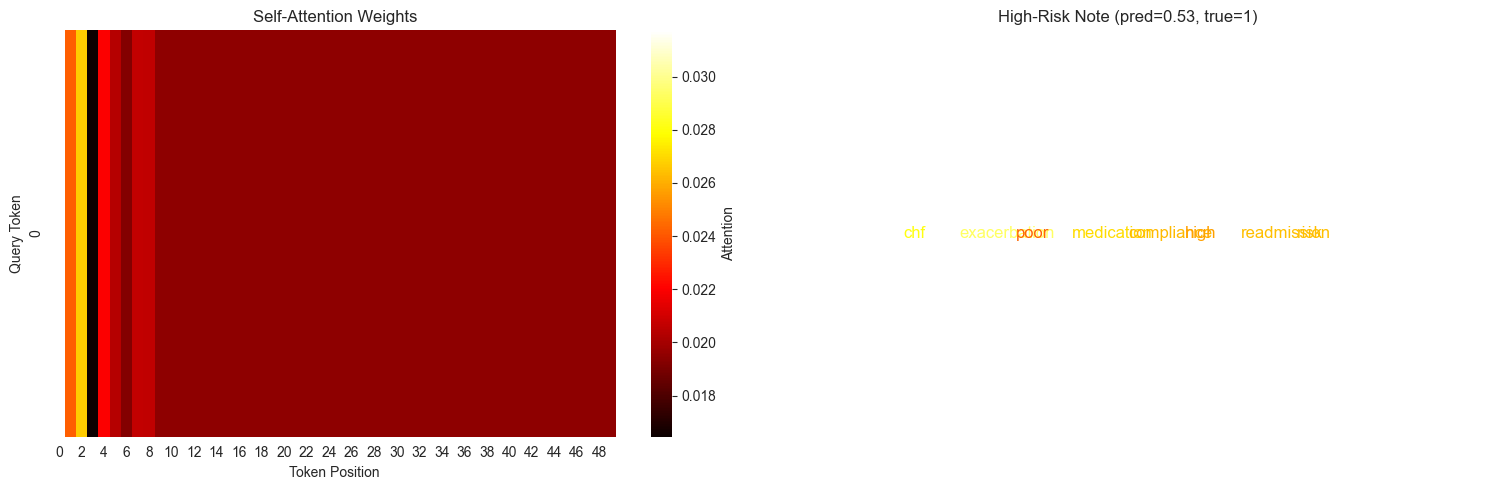

Sample tokens: recurrent chf exacerbation poor medication compliance high readmission risk
💡 Does attention highlight risk phrases?


In [ ]:
# Visualize top high-risk prediction
high_risk_idx = np.argmax(risk_pred.cpu().numpy())
sample_text_tokens = test_texts[high_risk_idx]
sample_weights = attn_weights[high_risk_idx, 0].cpu().numpy()  # First token's attention

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Attention heatmap
sns.heatmap(sample_weights.reshape(1,-1), ax=ax1, cmap='hot', cbar_kws={'label':'Attention'})
ax1.set_title('Self-Attention Weights')
ax1.set_xlabel('Token Position')
ax1.set_ylabel('Query Token')

# Highlighted text
highlight_scores = sample_weights[:len(sample_text_tokens)]
colors = plt.cm.hot(highlight_scores / highlight_scores.max())

for i, (token, score) in enumerate(zip(sample_text_tokens, highlight_scores)):
    ax2.text(0.1 + i*0.08, 0.5, token, fontsize=12, 
             color=plt.cm.hot(score / highlight_scores.max()), 
             transform=ax2.transAxes, va='center')

ax2.set_title(f'High-Risk Note (pred={risk_pred[high_risk_idx].item():.2f}, true={y_test_emb[high_risk_idx]})')
ax2.axis('off')

plt.tight_layout()
plt.savefig(OUTPUTS_DIR / 'attention_viz_lab3.png', dpi=300, bbox_inches='tight')
plt.show()

print("Sample tokens:", ' '.join(sample_text_tokens[:20]))


## Attention does highlight risk phrases